# Problem

$\blacktriangleright$ Here we tackle the solution of the incompressible Navier-Stokes equation for a non-newtonian fluid i.e. a fluid with a non-linear viscosity (power law). The problem will be considered steady in time

1. Considering the rectangular domain $\Omega$, the strong form of the problem is
\begin{equation}
    \begin{cases}
        -\text{div}(2\mu_{eff} D) +\nabla p=0 &\qquad in\thinspace \Omega\\
        \text{div}u=0  &\qquad in\thinspace \Omega\\
        u=y(1+y)  &\qquad on\thinspace \Gamma_1\\
        (-pI+2\mu_{eff} D)n=0  &\qquad in\thinspace \Gamma_{out}\\
        u=0  &\qquad in\thinspace \Gamma_{wall}\\
        u=u_{stokes} &\qquad in\thinspace \Omega
    \end{cases}
\end{equation}
where $\mu_{eff}=\mu_0\dot{\gamma}^{n-1}$ with $\dot{\gamma}=\sqrt{D:D}$ and $D=\frac{1}{2}(\nabla u +\nabla u^T)$ the symmetric strain-rate.</br> Here we see that the diffusion term is a trilinear form i.e. we have some non-linearities and since I'm using the ```LinearVariational..``` classes we have to linearize the problem or better Rearranging it all. The bi-linear forms in the LHS while the linear forms in the RHS as requested by the code. Now we can perform a while loop for the _Fixed Point_ when the tollerance is reached after k-iterations we converged. Since each iteration encompasses the solution of a linear-system we will have to solve k-linearized systems in order to reach the solution. The fluid profile is initialized solving the associated Stokes problem of the NS one.

2. Functional Spaces for trial, test fuctions for both velocity and pressure
$$V_0=[H^1_{\partial\Omega/\Gamma_{out}}(\Omega)]^2,\quad V_D=\{v \in [H^1(\Omega)]^2 : v=0\vert_{\Gamma_{walls}/\Gamma_{out}}, v=y(1+y)\vert_{\Gamma_{in}}\},\quad Q\in L^2(\Omega)$$

3. The weak formulation of the problem
\begin{align}
    2\int_{\Omega}\mu_{eff}D(u_{k+1}):D(v)d\Omega -\int_{\Omega}p_{k+1}\text{div}vd\Omega +\int_{\Omega}q\text{div}u_{k+1}d\Omega &=0\\
    2\int_{\Omega}\mu_0\bigg(\sqrt{D(u_{k}):D({u_{k}}})\bigg)^{n-1}D(u_{k+1}):D(v)d\Omega -\int_{\Omega}p_{k+1}\text{div}vd\Omega +\int_{\Omega}q\text{div}u_{k+1}d\Omega &=0
\end{align}
Considering the symmetric strain rate $D(u)$ inside the viscosity term $\mu_{eff}$ at the previous iteration step I basically linearized the problem, therefore transforming the original trilinear term in a bi-linear term, bi-linear in terms of $D(u_{k+1}),D(v)$.

4. Algorithms</br>
Here I used a direct algorithm for solving the linearized system, subsequently by means of PETSc the _LU factorization_, then the Lower (L) and the Upper (U) matrices that have been generated are solved using as backend the _MUMPS_ library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

---

Setup environment and output path

In [ ]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from firedrake.petsc import PETSc

In [ ]:
# Get current path: all relative paths that you may use for input/output start from here.
#
# - Colab:  The default path is /content, and your GDrive folder is accessible (if mounted) at /content/drive/MyDrive
#
# - local:  If running on your local machine, current_path is the position WHERE YOU LAUNCHED THE NOTEBOOK KERNEL BY 'jupyter notebook'
#           and NOT the directory in which this ipynb file is saved.
#           If you want to modify your current path, go to the terminal, stop the kernel (ctrl-C + press y), then move to the desired path by
#           cd my/desired/path/starting/from/here
#           and then launch 'jupyter notebook'.
import os
current_path = os.getcwd()
print(current_path)



basename = '...'
outfileU = File("/content/drive/MyDrive/velocity.pvd")
outfileP = File("/content/drive/MyDrive/pressure.pvd")


/content


/usr/local/lib/python3.11/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


In [ ]:
from firedrake.pyplot import triplot, tripcolor, quiver

---
---
# Exercise

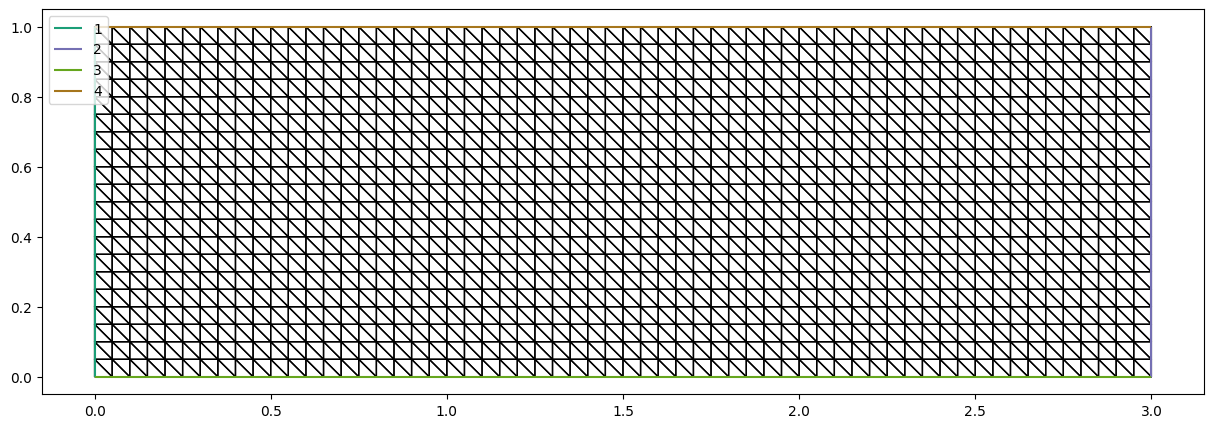

In [ ]:
# Create mesh
n=20
mesh = RectangleMesh(3*n, n, 3.0, 1.0)

fig, ax = plt.subplots(figsize=(15, 5))
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

### FE spaces, data, BCs

In [ ]:
# Function spaces
V=VectorFunctionSpace(mesh, 'P',2)
Q=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([V,Q])
# Data and boundary conditions
mu0 = 1
n = 1   # power-law exponent
f = Constant((0.,0.))
x = SpatialCoordinate(mesh)
u_in=(x[1]*(1-x[1]),0)

bc_in=DirichletBC(W.sub(0),u_in,1)
bc_wall=DirichletBC(W.sub(0),Constant((0,0)),(3,4))
bcs=(bc_in,bc_wall)

### Variational problems

In [ ]:
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions
u_old = Function(V)
p_old = Function(Q)

def Stokes_forms(u, v, p, q, mu, f):
    a_stokes = mu * inner(sym(grad(u)), sym(grad(v))) * dx - div(v) * p * dx + q * div(u) * dx
    L_stokes = dot(f, v) * dx
    return a_stokes, L_stokes


def Stokes_FP_forms(u, u_old ,v, p, q, mu, f):
    shear_stress=sqrt(inner(sym(grad(u_old)), sym(grad(u_old))) + 1e-10)
    mu_eff=mu0*shear_stress**(0.2-1)
    a_stokesFP = mu_eff * inner(sym(grad(u)), sym(grad(v))) * dx \
              - div(v) * p * dx\
               + q * div(u) * dx
    L_stokesFP = dot(f, v) * dx
    return a_stokesFP, L_stokesFP

### Initialization and definition of the ***linear*** solver for each nonlinear iteration.

In [ ]:
# Initialization solver
wh_init = Function(W)
a_init, L_init = Stokes_forms(u, v, p, q, mu0, f)
init_problem = LinearVariationalProblem(a_init, L_init, wh_init, bcs=bcs)
param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
solver_init =  LinearVariationalSolver(init_problem, solver_parameters=param)

# Actual initialization
solver_init.solve()
uh_init, ph_init = wh_init.subfunctions #soluzioni splittate! da passare al nuovo form

### Postprocessing of Stokes solution

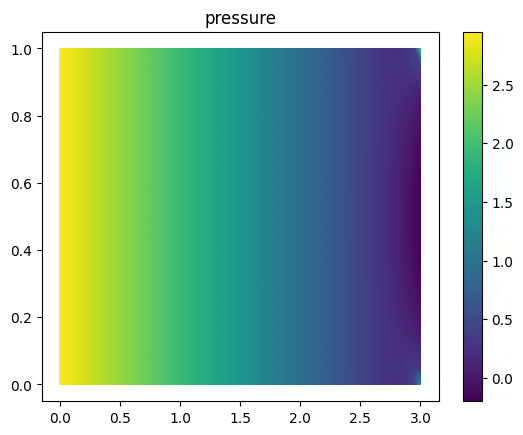

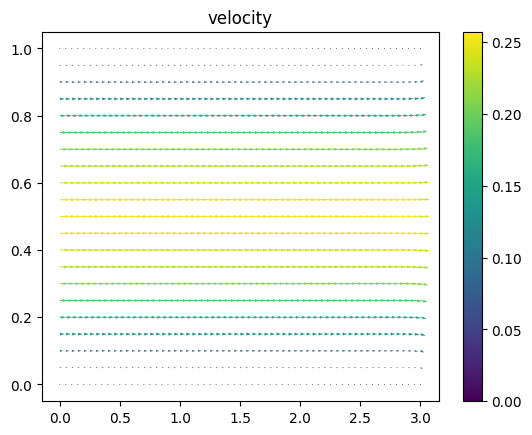

In [ ]:
# Plot of initial guess (Stokes solution)
fig, ax = plt.subplots()
col = tripcolor(ph_init, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh_init, axes=ax)
plt.colorbar(col)
plt.title('velocity')

# vtk output for Paraview
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)


In [ ]:
wh=Function(W) #store soluzione FP

uh_old=Function(V)
uh_old.assign(uh_init)  #compilo la viscosità al time-step precedente e quindi viene inizializzata con la soluzione di stokes-semplice
p_old = Function(Q)
p_old.assign(ph_init)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x797118b46b90>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 997)), 1995)

In [ ]:
# Step 1
param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
a_st, L_st= Stokes_FP_forms(u, u_old ,v, p, q, mu_eff, f)
st1=LinearVariationalProblem(a_st, L_st,wh,bcs)
solver =  LinearVariationalSolver(st1, solver_parameters=param)
#solver.solve()

In [ ]:
maxit = 100
it = 0
tol = 1e-3
err = tol+1     # >tol in order to enter the loop at the beginning

while it <= maxit and err > tol:

    it += 1

    solver.solve()          #Risolvo il problema non-lineare
    uh,ph = wh.subfunctions #estrazione della soluzione non lineare a t=t^{n}, cioè la soluzione appena ottenuta!!, l'obbiettivo è ottenere la nuova soluzione a t^{n} che poi riutilizzerò come u_old e ripeto il ciclo

    a_st, L_st= Stokes_FP_forms(u, u_old ,v, p, q, mu_eff, f)
    st1=LinearVariationalProblem(a_st, L_st,wh,bcs)

    err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') +
           errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))

    print("Iteration = ", it, " Error = ", err)
    uh.rename("Velocity")
    #ph.rename("Pressure")
    outfileU.write(uh)
    #outfileP.write(ph)

    u_old.assign(uh) # update the old solution
    p_old.assign(ph) # update the old solution

if it <= maxit:
    print('Nonlinear solver converged in', it, 'iterations.')
else:
    print('Nonlinear solver di NOT converge!\nRelative error =', err, 'after', it, 'iterations.')

<ipython-input-244-bdcf074c5419>:16: RuntimeWarning: divide by zero encountered in scalar divide
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') +


Iteration =  1  Error =  inf
Iteration =  2  Error =  1.1828566427322977
Iteration =  3  Error =  0.1543486781557257
Iteration =  4  Error =  0.0956057061602653
Iteration =  5  Error =  0.06382449601324125
Iteration =  6  Error =  0.04482607588191315
Iteration =  7  Error =  0.03243260150673437
Iteration =  8  Error =  0.02393992258845719
Iteration =  9  Error =  0.0179419854070362
Iteration =  10  Error =  0.013602462642668203
Iteration =  11  Error =  0.010404550588494394
Iteration =  12  Error =  0.008011981656422057
Iteration =  13  Error =  0.00620141275722905
Iteration =  14  Error =  0.004819260453011101
Iteration =  15  Error =  0.0037568436559253476
Iteration =  16  Error =  0.0029357922114817974
Iteration =  17  Error =  0.0022986239385903236
Iteration =  18  Error =  0.001802543895785461
Iteration =  19  Error =  0.001415313587243755
Iteration =  20  Error =  0.0011124243147750987
Iteration =  21  Error =  0.0008751100775744682
Nonlinear solver converged in 21 iterations.


Text(0.5, 1.0, 'velocity')

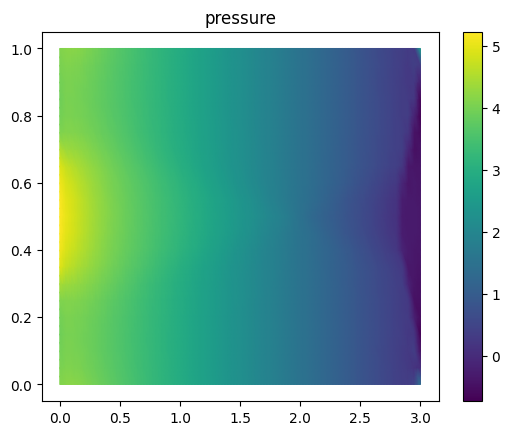

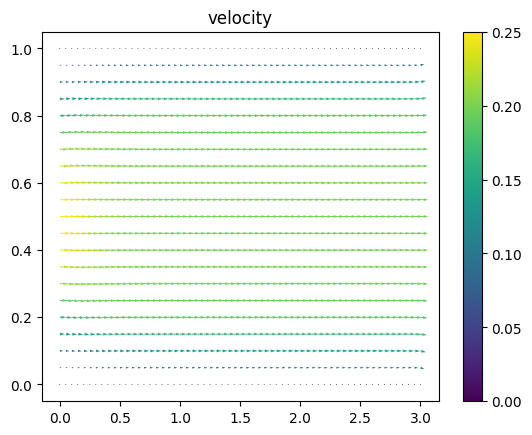

In [ ]:
fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')